## 导库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from scipy import  stats
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
import warnings
register_matplotlib_converters()
warnings.filterwarnings("ignore")

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## 导入数据

In [2]:
path = '比特币.csv'

df = pd.read_csv(path,encoding='UTF-8')

### 展示数据

In [4]:
df.index = pd.to_datetime(df['Timestamp'])
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,,
2020-03-31 00:00:00,2020/3/31 0:00,6408.95,6408.95,6397.52,6397.65,0.369580,2366.046893,6401.994344
2020-03-31 00:01:00,2020/3/31 0:01,6399.20,6406.06,6398.80,6405.06,4.053499,25960.527670,6404.473810
2020-03-31 00:02:00,2020/3/31 0:02,6409.05,6425.24,6409.05,6425.00,18.707374,120144.266200,6422.294481
2020-03-31 00:03:00,2020/3/31 0:03,6417.53,6430.74,6417.53,6426.53,7.164653,46043.367360,6426.461704
2020-03-31 00:04:00,2020/3/31 0:04,6426.54,6438.96,6424.46,6438.96,9.050250,58225.624100,6433.592825


## 数据探索和预处理：时间序列数据需要统计其时间序列趋势，如走势、自相关性、异方差性

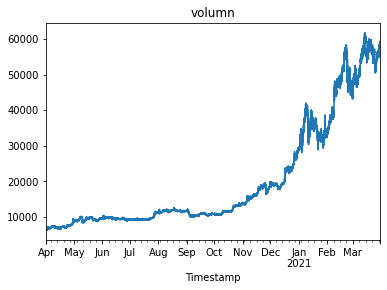

In [4]:
#看看这玩意的收盘价走势
df['Close'].plot(title = "volumn")
plt.show()

## 计算指标

本文是HAR模型，只计算收益率和日、周、月波动率，如果是HAR进阶模型，要引入跳跃、跳跃强度

In [7]:
df['return'] = (df['Close']-df['Close'].shift())/df['Close'] #计算时间点的收益率

In [8]:
#计算每日的已实现波动率，volomns传入收盘价的列名
def rv(df,volomns):
    df['D'] = df.index.date
    n_periods = df.pivot_table(index = ['D'],aggfunc='size').values #将相同日期不同时间点的数据集合在一起，统计出每天的日期频率有多少
    print(stats.describe(n_periods))
    
    df.loc[df['D'] != df['D'].shift(),"Per"]= n_periods #新加一列叫per的列，用来保存每天的时间频率
    df.fillna(method = 'ffill',inplace = True)
    

    #计算每日收益率的平方（np.where函数满足cond条件输出x，不满足输出y）
    df ["Ret"] = np.where(df['D']==df['D'].shift(),np.nan,((df[volomns]-df[volomns].shift())* 1/df["Per"])**2)

    test = df[volomns]-df[volomns].shift()
    test2 = test* 1/df["Per"]
    test3 = test2**2
    #求和
    rv = df.groupby('D')["Ret"].agg(np.sum).to_frame()
    rv.columns = ["RV_daily"]
    #再开根号，算每一天的波动率
    rv["RV_daily"] = np.sqrt(rv["RV_daily"])
    print(rv.tail())
    return rv
    #返回是一个df

In [9]:
#调用一下
rv = rv(df,'return')

DescribeResult(nobs=366, minmax=(1, 1440), mean=1436.068306010929, variance=5657.707650273223, skewness=-19.052630782283785, kurtosis=361.0027397260275)
                RV_daily
D                       
2021-03-27  2.491659e-06
2021-03-28  1.394145e-06
2021-03-29  2.812240e-07
2021-03-30  1.256314e-06
2021-03-31  3.261585e-04


In [10]:
#周波动率
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()

#月波动率
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)


print(rv.head())
print(rv.describe())

print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV : ",adf (rv["RV_weekly"].values)[1])
print("p-value for monthly RNV :",adf (rv["RV_monthly"].values)[1])

                RV_daily     RV_weekly  RV_monthly
D                                                 
2020-04-20  3.614653e-07  1.573302e-06    0.000002
2020-04-21  1.655107e-06  1.352954e-06    0.000002
2020-04-22  1.937764e-07  9.850049e-07    0.000002
2020-04-23  6.785857e-08  4.998532e-07    0.000002
2020-04-24  7.867929e-07  6.130000e-07    0.000002
           RV_daily     RV_weekly    RV_monthly
count  3.460000e+02  3.460000e+02  3.460000e+02
mean   2.054900e-06  1.306247e-06  1.165335e-06
std    1.751148e-05  3.567435e-06  1.026497e-06
min    0.000000e+00  1.642758e-07  4.207744e-07
25%    3.573349e-07  6.100243e-07  6.624073e-07
50%    7.828115e-07  9.126763e-07  9.086513e-07
75%    1.486170e-06  1.643269e-06  1.553340e-06
max    3.261585e-04  6.631636e-05  1.742454e-05
p-value for daily RV: 0.9953007194439373
p-value for weekly RV :  0.9949417581540798
p-value for monthly RNV : 0.9970322390549956


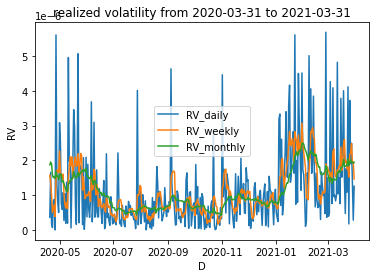

In [12]:
#绘制三条波动率线的图
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"realized volatility from {df. index.date[0]} to {df.index.date[-1]}")
plt.ylabel("RV")
plt.show()


#下一日波动率
rv["Target"] = rv["RV_daily"].shift(-1)
rv.dropna(inplace = True)

#最小最大值标准化
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

rv_scaled = sm.add_constant(rv_scaled)

## 划分数据集并建立预测模型

In [13]:
#划分训练集
split = int(0.60 * rv.shape[0])
X= rv_scaled.drop("Target",axis = 1)
y = rv_scaled[["Target"]]
X_train,X_test = X[:split],X[split:]
y_train,y_test = y[:split],y[split:]


#回归和拟合结果，分析P值是否显著
result = sm.OLS(y_train,X_train).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     4.616
Date:                Tue, 08 Aug 2023   Prob (F-statistic):            0.00380
Time:                        19:37:18   Log-Likelihood:                 78.244
No. Observations:                 206   AIC:                            -148.5
Df Residuals:                     202   BIC:                            -135.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1026      0.021      4.980      0.000       0.062       0.143
RV_daily      -0.0271      0.080     -0.338      0.736      -0.186       0.131
RV_weekly     -0.0012      0.104     -0.012      0.990      -0.207       0.204
RV_monthly     0.2319      0.084      2.766      0.006       0.067       0.397
==============================================================================
Omnibus:                      118.069   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              582.972
Skew:                           2.314   Prob(JB):                    2.57e-127
Kurtosis:                       9.819   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

看起来您已经提供了线性回归模型的汇总统计数据。以下是信息的细分：

因变量：“目标”：这是您尝试在线性回归模型中预测的变量。

R 平方：0.060：R 平方值表示因变量（目标）中的方差可以由模型中的自变量解释的比例。在本例中，R 平方值为 0.060，这表明目标变量中大约 6% 的方差由模型中的自变量解释。

模型：OLS（普通最小二乘法）：OLS 是线性回归建模的常用方法。

调整。R 平方：0.046：调整后的 R 平方是 R 平方的修改版本，可根据模型中自变量的数量进行调整。它会因为添加不必要的变量而对 R 平方值进行惩罚。在这种情况下，调整后的 R 平方为 0.046。

方法：最小二乘法：用于估计模型参数的方法是最小二乘法。

F 统计量：4.268：F 统计量是总体模型对数据的拟合程度的度量。它检验自变量和因变量之间是否存在显着关系。F 统计量越大表明拟合效果越好。相关概率 (Prob (F-statistic)) 为 0.00601，它是 F 检验的 p 值。

日期：2023 年 8 月 7 日星期一：估计模型的日期。

时间：20:11:55：模型估算的时间。

对数似然：75.038：对数似然是模型预测观测数据的好坏的度量。

编号观测值：206：用于估计模型的数据点（观测值）的数量。

AIC（赤池信息准则）：-142.1：AIC 是模型拟合优度的度量，根据模型中的参数数量进行调整。AIC 值越低表示拟合越好。

Df Residuals：202：残差的自由度，即观测值数量与模型参数数量之差。

BIC（贝叶斯信息准则）：-128.8：BIC 与 AIC 类似，但因添加额外变量而受到更严重的惩罚。与 AIC 一样，BIC 值越低表示拟合越好。

Df Model：3：模型的自由度，即模型中自变量的数量。

协方差类型：非鲁棒：这表示估计模型时使用的协方差类型。在这种情况下，使用非鲁棒协方差类型。

coef：模型中自变量的估计系数（斜率）。

std err：估计系数的标准误差。

t：t 统计量，衡量系数的显着性。它是系数与其标准误差的比率。

P>|t|：与 t 统计量相关的 p 值。它表示在原假设（系数为零）下观察 t 统计量的概率。

[0.025 0.975]：每个系数的置信区间。它提供了一个范围，在该范围内我们可以合理地确信系数的真实值。

综合：115.068：综合检验是对残差正态性的检验。在本例中，检验统计量为 115.068。

Durbin-Watson：2.001：Durbin-Watson 检验用于检测残差中是否存在自相关。2 左右的值表示没有自相关。

Prob(Omnibus)：0.000：与 Omnibus 检验相关的 p 值，表明残差不呈正态分布。

Jarque-Bera (JB)：542.868：Jarque-Bera 检验是残差正态性的另一种检验。较大的 JB 统计量和较低的 p 值表明残差不呈正态分布。

Skew：2.263：残差的偏度，衡量分布的不对称性。

Prob(JB)：1.31e-118：与 Jarque-Bera 检验相关的 p 值，表明残差不呈正态分布。

峰度：9.539：残差的峰度，用于测量分布的“尾部”。

条件。编号：11.5：条件数是多重共线性的度量。条件数大表明自变量之间存在高度多重共线性。

## 查看模型效果

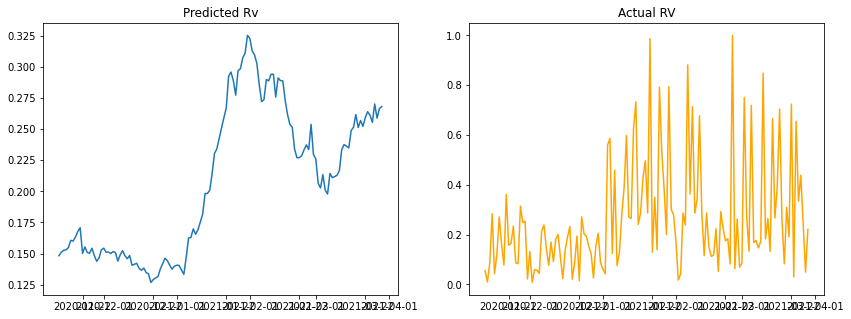

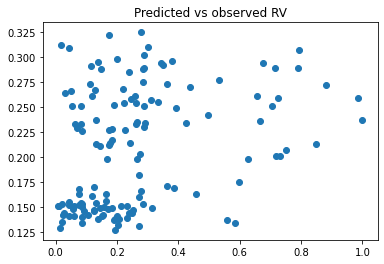

In [14]:
#测试集预测结果和真实结果分布图，越靠近45度线越好
y_hat = result.predict(X_test)
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
plt.plot(y_test.index,y_hat)
plt.title("Predicted Rv")

plt.subplot(1,2,2)
plt.plot(y_test.index,y_test.values,color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test,y_hat)
plt.title("Predicted vs observed RV")
plt.show()

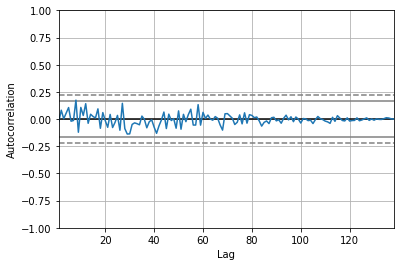

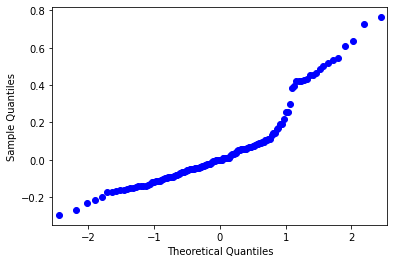

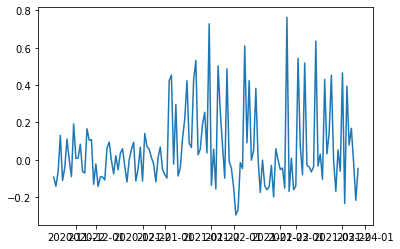

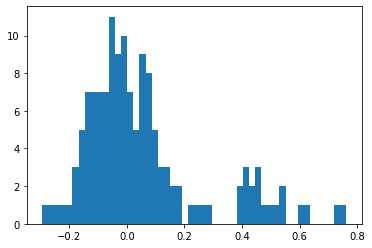

In [15]:
#残差
residuals = y_test.values.ravel() - y_hat
#自相关系数
autocorrelation_plot(residuals)
plt.show()

qqplot(residuals)
plt. show()
plt.plot(residuals)
plt.show()
plt.hist(residuals,bins = 50)
plt.show()

##  后面还可以计算一下MSE，R方，MAE，混淆矩阵进行一下模型评价，如模型置信度检验、样本外 R2 检验、趋势检验

In [16]:
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [17]:
#In-sample scores
print("In-sample scores")

y_hat_is = result.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.028257257605391675, R^2:0.059601768175848835, MAE:0.1120177062320333
----------------
Out-of-sample scores
MSE:0.047504068457357544, R^2:0.03539048468267436, MAE:0.14591245865679864


In [18]:
#可释方差得分
from sklearn.metrics import explained_variance_score
score = explained_variance_score(y_test, y_hat)
print( 'evs: %.2f%%'% ( score*100.0 ))

evs: 10.18%


## 计算跳跃和跳跃强度